In [11]:
os.path.join('ssd_mobilenet_v1_coco_11_06_2017','frozen_inference_graph.pb' )

'ssd_mobilenet_v1_coco_11_06_2017\\frozen_inference_graph.pb'

'DOG' detected with confidence 0.9981639981269836 in [385.2794494628906, 35.94230845570564, 618.0170593261719, 574.7251865565777]
'DOG' detected with confidence 0.9976660013198853 in [33.287445068359375, 17.83781325817108, 288.8041687011719, 533.6747478246689]
'PERSON' detected with confidence 0.9973537921905518 in [215.52914941310883, 699.2642283439636, 52.75322937965393, 156.70607686042786]
'KITE' detected with confidence 0.9956830739974976 in [593.4115681648254, 84.60910320281982, 79.4232759475708, 71.17646634578705]
'PERSON' detected with confidence 0.9891179203987122 in [120.35570335388184, 613.230550289154, 48.63386082649231, 150.86776614189148]
'PERSON' detected with confidence 0.9618873596191406 in [80.15357178449631, 508.71586203575134, 24.139189064502716, 56.58184289932251]
'KITE' detected with confidence 0.9199441075325012 in [279.08983850479126, 239.10930454730988, 27.88404667377472, 40.05474150180817]
'KITE' detected with confidence 0.8729959726333618 in [1086.628550052642

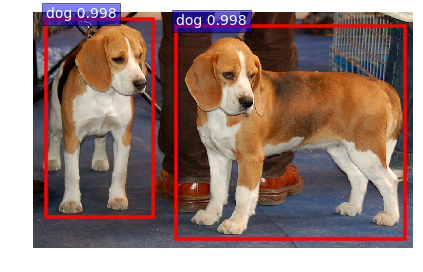

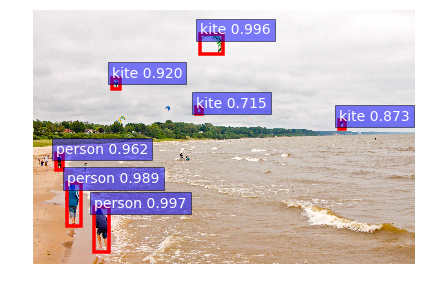

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
import time
sys.path.append("..")  #Not sure if I need this line if I run it in the parental directory
from utils import label_map_util

MODELS = ['ssd_mobilenet_v1_coco_2017_11_17', 'ssd_inception_v2_coco_11_06_2017',\
                  'rfcn_resnet101_coco_11_06_2017', 'faster_rcnn_resnet101_coco_11_06_2017',\
                   'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017', 'faster_rcnn_inception_v2_coco_2017_11_08']
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
def vis_detections(img_path, outputs):
    """Draw detected bounding boxes."""
    im = cv2.imread(img_path)
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    
    for output in outputs:
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']   
      

        ax.add_patch(
            plt.Rectangle((x, y),
                          width,
                          height, fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(x, y - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')


    plt.axis('off')
    plt.tight_layout()
    plt.draw()




NUM_CLASSES = 90
PATH_TO_LABELS = "data/mscoco_label_map.pbtxt"
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


#Get the session from the specified model
def load_model(model, dynamic_memory=True):
    
    #Dynamically allocating memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=dynamic_memory
    sess = tf.Session(config=config)    
    PATH_TO_CKPT = os.path.join(model , 'frozen_inference_graph.pb')
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
    return tf.Session(graph=detection_graph, config=config)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def translate_result(boxes, scores, classes, num_detections, im_width, im_height, thresh):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask]
    
    outputs = []        
    for i, score in enumerate(scores):      
        #Stop when score is lower than threshold since the score is sorted
        #!!!!Performance of this line can be improved!!!！
       

        class_name = category_index[classes[i]]['name']
        ymin, xmin, ymax, xmax = boxes[i]
        left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                  ymin * im_height, ymax * im_height)          
        #Allocating result into ouput dict
        output = {}        
        output['score'] = score
        output['class'] = class_name
        output['x'] = left
        output['y'] = top
        output['width'] = right-left
        output['height'] = bottom-top
        #Append each detection into a list
        outputs.append(output)
    return outputs


def detect(sess, img_path, thresh=0.7):
    img = Image.open(img_path)
    img_width, img_height = img.size
    img_np = load_image_into_numpy_array(img)
    img_np_expanded = np.expand_dims(img_np, axis=0)
    
    #Initalization of output and input tensors for session
    img_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    scores = sess.graph.get_tensor_by_name('detection_scores:0')
    classes = sess.graph.get_tensor_by_name('detection_classes:0')
    num_detections = sess.graph.get_tensor_by_name('num_detections:0')
    
    outputs = [boxes, scores, classes, num_detections]
    feed_dict = {img_tensor: img_np_expanded}
    boxes, scores, classes, num_detections = sess.run(outputs,feed_dict=feed_dict) 
 
    return translate_result(boxes, scores, classes, num_detections, img_width,\
                            img_height,thresh)
    
if __name__ == "__main__":
    TEST_IMAGE_PATHS = [os.path.join("test_images",\
                                     'image{}.jpg'.format(i)) for i in range(1,3)]
    THRESHOLD = 0.7
    model = MODELS[5]
    sess = load_model(model)
    for img_path in TEST_IMAGE_PATHS:
        result = detect(sess, img_path, thresh=THRESHOLD)
        outputs = result
        for output in outputs:                     
            score = output['score'] 
            class_name = output['class']
            x = output['x']
            y = output['y']
            width = output['width']
            height = output['height']                       
            print("'{}' detected with confidence {} in [{}, {}, {}, {}]".format(class_name.upper(),\
                                                                              score, x, y, width,\
                                                                              height)) 
        vis_detections(img_path, outputs)

'CAR' detected with confidence 0.948397696018219 in [138.830217897892, 364.51281094551086, 91.0066250860691, 51.88723576068878]
'CAR' detected with confidence 0.945468008518219 in [21.82130535878241, 247.721058011055, 34.47974999807775, 31.96803081035614]
'TRUCK' detected with confidence 0.9307229518890381 in [89.69557522237301, 249.85790383815765, 61.248309284448624, 53.118658661842346]
'POTTED PLANT' detected with confidence 0.915450394153595 in [331.1245992779732, 342.1344884634018, 29.352121353149414, 38.10078728199005]
'SUITCASE' detected with confidence 0.7798858284950256 in [155.8277019560337, 213.56373703479767, 52.889617413282394, 54.216758608818054]
'CAR' detected with confidence 0.9693255424499512 in [172.1009812951088, 311.67573297023773, 87.00323659181595, 52.883138597011566]
'TRUCK' detected with confidence 0.8766075968742371 in [96.27189415693283, 250.1118718981743, 54.547263741493225, 50.7328262925148]
'POTTED PLANT' detected with confidence 0.8417483568191528 in [280.6

'CAR' detected with confidence 0.9150581359863281 in [345.93619108200073, 98.49556684494019, 25.248312950134277, 18.63088607788086]
'TRUCK' detected with confidence 0.8834228515625 in [267.3652946949005, 147.23974466323853, 90.61086773872375, 146.35125398635864]
'CAR' detected with confidence 0.876327633857727 in [475.5183935165405, 125.95008611679077, 24.394047260284424, 24.346840381622314]
'TRUCK' detected with confidence 0.824998676776886 in [382.6286315917969, 87.64180541038513, 51.704514026641846, 83.73242020606995]
'TRUCK' detected with confidence 0.7571866512298584 in [379.85823154449463, 168.34087371826172, 123.27500581741333, 208.32927227020264]
'CAR' detected with confidence 0.755120038986206 in [435.3212356567383, 111.00937128067017, 15.48614501953125, 23.726987838745117]
'TRUCK' detected with confidence 0.7236924171447754 in [174.69627857208252, 71.84010744094849, 159.01511907577515, 126.32713317871094]
'MOTORCYCLE' detected with confidence 0.9543112516403198 in [621.493678

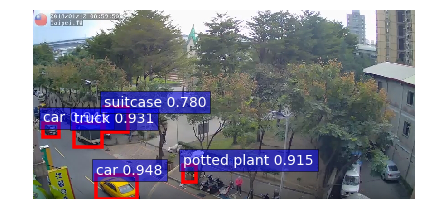

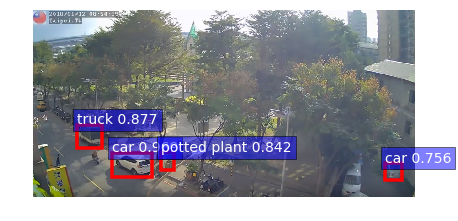

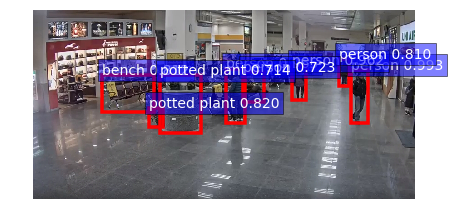

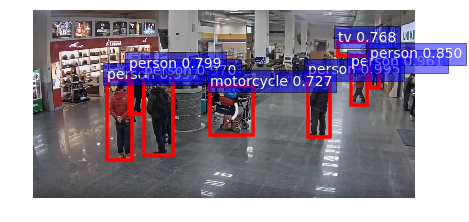

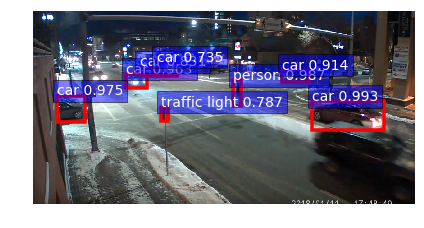

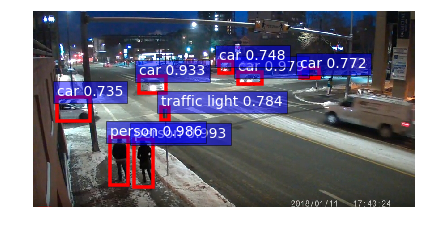

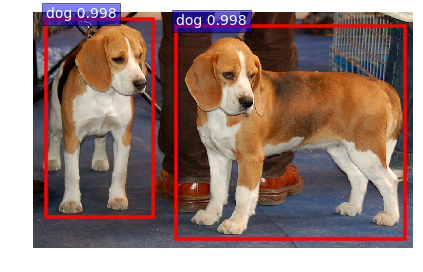

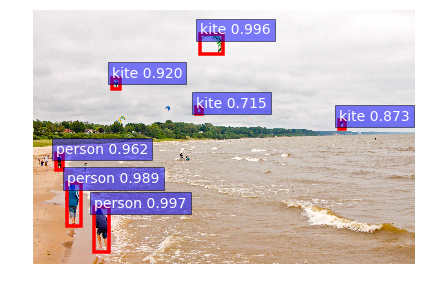

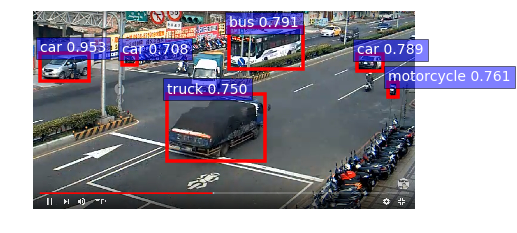

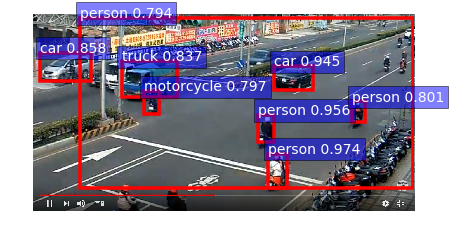

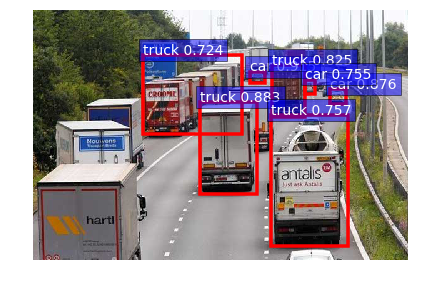

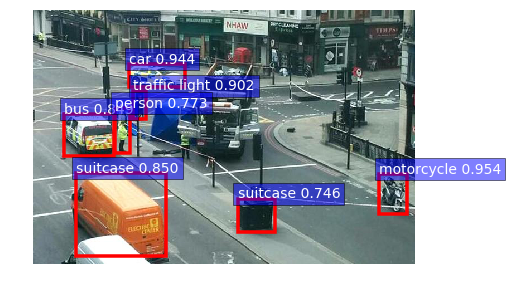

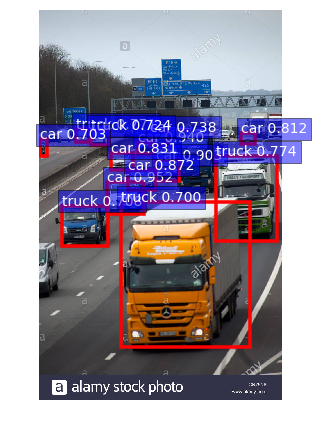

In [5]:
import glob
TEST_IMAGE_PATHS = glob.glob('test_images/*.jpg')
THRESHOLD = 0.7
for img_path in TEST_IMAGE_PATHS:
    result = detect(sess, img_path, thresh=THRESHOLD)
    outputs = result
    for output in outputs:                     
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']                       
        print("'{}' detected with confidence {} in [{}, {}, {}, {}]".format(class_name.upper(),\
                                                                              score, x, y, width,\
                                                                              height)) 
    vis_detections(img_path, outputs)